## The Andong Kwŏn Genealogy of 1476: Page-by-Page Inspection Notebook

This Jupyter notebook offers two complementary workflows for working with the facsimile of the *Andong Kwŏn Genealogy of 1476* (*Andong Kwŏn ssi Sŏnghwabo* 安東權氏成化譜):

| Workflow | Purpose | How to Invoke |
|----------|---------|---------------|
| **Single-page inspection** | Quickly render an individual leaf (recto/verso) as a high-resolution preview for close reading or annotation. | Locate the code cell that begins with `# Single page inspection` and set `volume`, `leaf`, and `side` (either `"a"` for recto or `"b"` for verso). Run the cell. |
| **Batch export** | Generate **PNG** and **SVG** files for *every* page across all three volumes, suitable for downstream processing or web delivery. | Execute the batch-export section near the end of the notebook. |

---

### Font configuration for rare Sinitic glyphs

Rendering a premodern Korean genealogy demands a typeface with an unusually broad Unicode repertoire. After extensive testing, **Noto Serif CJK JP** has proven the least imperfect choice; **Noto Serif CJK TC** struggled with several uncommon glyphs. No single font, however, covers the entire Unicode Sinitic block range, so occasional blank glyph boxes (□) are inevitable.

---

### Prerequisites

The notebook expects an active **Neo4j** instance:

1. **Install** Neo4j Desktop *or* Neo4j Server (community/enterprise edition works equally well).  
2. Ensure the **Bolt** listener is running at `bolt://localhost:7687`.  
3. Use the default username `neo4j` and supply your own password in the code cell that initialises the driver. **Never** commit this credential to a public repository.
4. **Import the dataset** first by running `Andong Kwon Genealogy Import.ipynb`. The inspection notebook presumes the nodes and relationships are already in place.

If you prefer to run a remote Neo4j instance, adjust the Bolt URI, but excise those details before publishing or sharing the notebook.

---


### Caveats

While this notebook strives for accuracy, OCR and glyph coverage limitations mean that **rare ideographs may fail to render** or render inaccurately. Always cross-check against the original scans when transcribing or quoting unusual characters.

In [7]:
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import re
import os

In [8]:
#driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", ""))

**Note:** The complete **Noto Serif CJK** set (162 MB) is too large to host on GitHub. Instead, download the consolidated **Super OTC** package from the [official repository](https://github.com/notofonts/noto-cjk/tree/main/Serif#downloading-noto-serif-cjk).

In [9]:
import matplotlib.font_manager as fm
fm.fontManager.addfont("fonts/NotoSerifCJK.ttc")
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
noto_available = [f.name for f in fm.fontManager.ttflist if "Noto Serif" in f.name]
print("Noto Serif fonts found:", noto_available)

Noto Serif fonts found: ['Noto Serif TC', 'Noto Serif JP', 'Noto Serif TC', 'Noto Serif TC', 'Noto Serif Myanmar', 'Noto Serif Yezidi', 'Noto Serif CJK TC', 'Noto Serif JP', 'Noto Serif TC', 'Noto Serif Ahom', 'Noto Serif TC', 'Noto Serif TC', 'Noto Serif JP', 'Noto Serif Balinese', 'Noto Serif Kannada', 'Noto Serif TC', 'Noto Serif Hmong Nyiakeng', 'Noto Serif TC', 'Noto Serif CJK JP', 'Noto Serif CJK JP']


In [10]:
# Create output directories if they don't exist.
os.makedirs("inspection/png", exist_ok=True)
os.makedirs("inspection/svg", exist_ok=True)

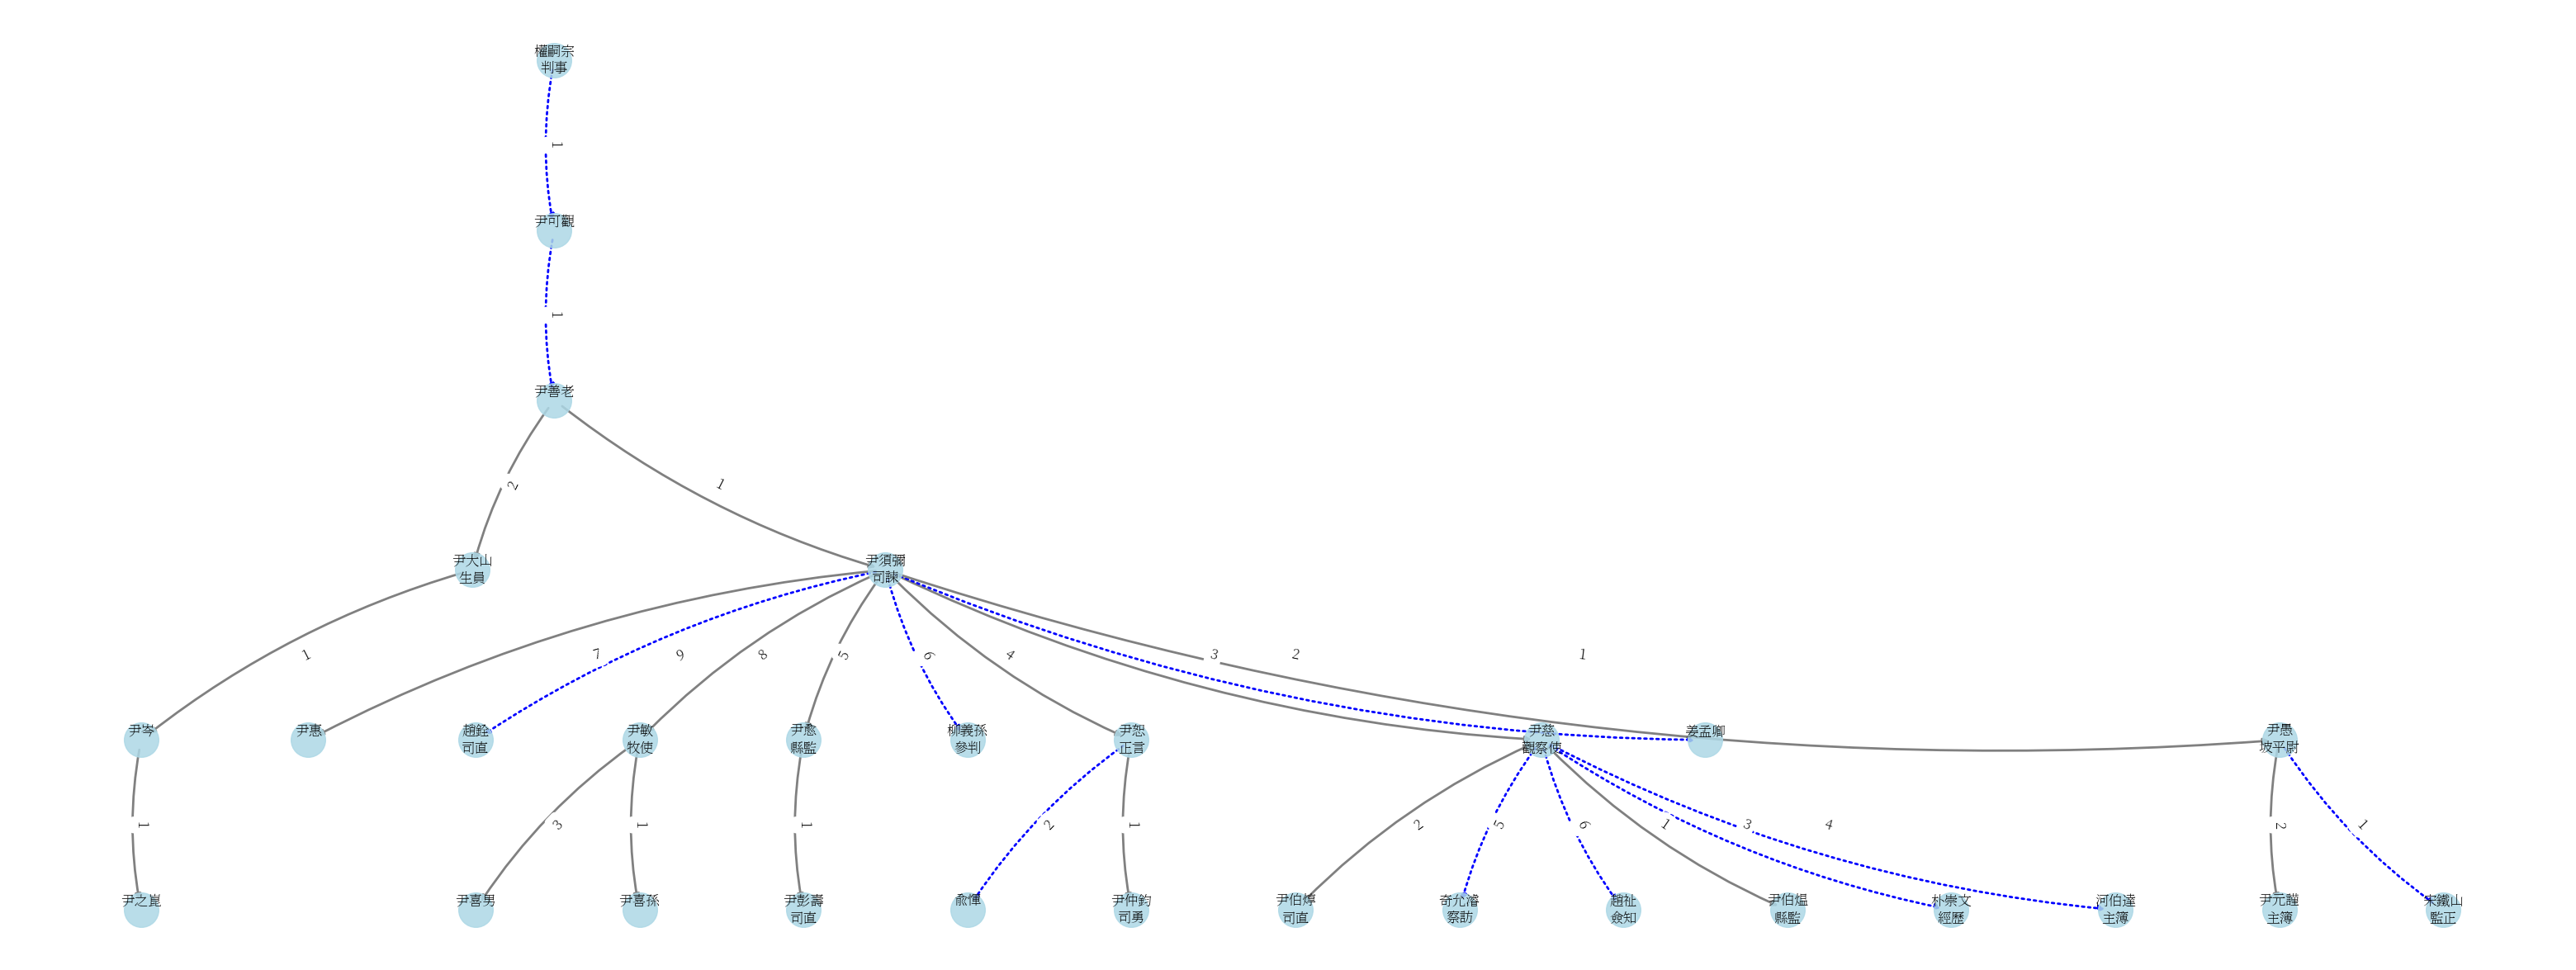

In [11]:
# Single page inspection:
vol = 3
leaf = 16
side = "b"

with driver.session() as session:
    result = session.run(f"""
        MATCH path = ()-[r]->()
        WHERE r.vol = {vol} AND r.leaf = {leaf} AND r.side = '{side}' AND r.reference = '安東權氏成化譜'
        RETURN path
    """)

    edges_list = []
    nodes_list = []
    node_id_to_name = {}

    for record in result:
        path = record['path']

        for relationship in path.relationships:
            start_node = relationship.start_node
            end_node = relationship.end_node

            start = start_node['biog_id']
            end = end_node['biog_id']

            relationship_type = relationship.type
            child_order = relationship.get('child_order', None)

            edges_list.append((start, end, relationship_type, child_order))

        for node in path.nodes:
            biog_id = node['biog_id']
            node_name = node['name']
            office_final = node.get('office', '')

            node_name_str = ', '.join(node_name) if isinstance(node_name, list) else node_name
            node_key = (biog_id, node_name_str)
            if node_key not in node_id_to_name:
                nodes_list.append((biog_id, node_name_str, office_final))
                node_id_to_name[node_key] = True

edges = pd.DataFrame(edges_list, columns=['source', 'target', 'type', 'child_order'])
nodes = pd.DataFrame(nodes_list, columns=['biog_id', 'name', 'office'])
edges.drop_duplicates(subset=['source', 'target'], inplace=True)
edges.sort_values(by=['source', 'target', 'child_order'], inplace=True, ascending=False)

biog_id_to_name = dict(zip(nodes['biog_id'], nodes['name']))

G = nx.from_pandas_edgelist(edges, 'source', 'target', ['type', 'child_order'], create_using=nx.DiGraph())

root = [node for node, degree in G.in_degree() if degree == 0][0]

pos = graphviz_layout(G, prog='dot', root=root)

plt.figure(figsize=(40, 15))

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=900, alpha=0.85)

edge_styles = {'HAS_SON': 'solid', 'HAS_SIL': 'dotted'}
color_dict = {'HAS_SON': 'grey', 'HAS_SIL': 'blue'}

for (u, v, data) in G.edges(data=True):
    edge_type = data['type']
    if re.match(r'^HAS_SON', edge_type):
        edge_style = edge_styles['HAS_SON']
        edge_color = color_dict['HAS_SON']
    elif re.match(r'^HAS_SIL', edge_type):
        edge_style = edge_styles['HAS_SIL']
        edge_color = color_dict['HAS_SIL']
    else:
        edge_style = 'solid'
        edge_color = 'black'
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], style=edge_style, edge_color=edge_color, connectionstyle='arc3,rad=0.1', width=2)


labels = {node: f"{biog_id_to_name[node]}\n{nodes.loc[nodes['biog_id'] == node, 'office'].values[0]}" for node in G.nodes if node in biog_id_to_name}

nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_family='Noto Serif CJK JP')

edge_labels = {(u, v): data['child_order'] for u, v, data in G.edges(data=True)}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_family='Noto Serif CJK JP')

plt.box(False)

plt.savefig(f'inspection/png/vol{vol}_{leaf}{side}.png', dpi=150)
plt.savefig(f'inspection/svg/vol{vol}_{leaf}{side}.svg', format='svg')

In [12]:
# Batch generate visualizations for page-by-page inspection.

# Define leaf limits per volume.
volume_limits = {
    1: (57, True),  # ends with 57b
    2: (54, True),  # ends with 54b
    3: (71, False)  # ends with 71a only
}

for vol, (max_leaf, include_b) in volume_limits.items():
    for leaf in range(1, max_leaf + 1):
        for side in ['a', 'b']:
            if side == 'b' and not include_b and leaf == max_leaf:
                continue  # skip 71b for vol 3

            with driver.session() as session:
                result = session.run(f"""
                    MATCH path = ()-[r]->()
                    WHERE r.vol = {vol} AND r.leaf = {leaf} AND r.side = '{side}'
                          AND r.reference = '安東權氏成化譜'
                    RETURN path
                """)

                edges_list = []
                nodes_list = []
                node_id_to_name = {}

                for record in result:
                    path = record['path']

                    for relationship in path.relationships:
                        start = relationship.start_node['biog_id']
                        end = relationship.end_node['biog_id']
                        edges_list.append((
                            start,
                            end,
                            relationship.type,
                            relationship.get('child_order', None)
                        ))

                    for node in path.nodes:
                        biog_id = node['biog_id']
                        node_name = node['name']
                        office_final = node.get('office', '')
                        node_name_str = ', '.join(node_name) if isinstance(node_name, list) else node_name
                        node_key = (biog_id, node_name_str)
                        if node_key not in node_id_to_name:
                            nodes_list.append((biog_id, node_name_str, office_final))
                            node_id_to_name[node_key] = True

                if not edges_list:
                    print(f"Vol {vol}, leaf {leaf}{side}: no data.")
                    continue  # skip empty paths

                # Build graph.
                edges = pd.DataFrame(edges_list, columns=['source', 'target', 'type', 'child_order'])
                nodes = pd.DataFrame(nodes_list, columns=['biog_id', 'name', 'office'])
                edges.drop_duplicates(subset=['source', 'target'], inplace=True)
                edges.sort_values(by=['source', 'target', 'child_order'], inplace=True, ascending=False)

                biog_id_to_name = dict(zip(nodes['biog_id'], nodes['name']))
                G = nx.from_pandas_edgelist(edges, 'source', 'target', ['type', 'child_order'], create_using=nx.DiGraph())

                try:
                    root = [node for node, degree in G.in_degree() if degree == 0][0]
                except IndexError:
                    print(f"Vol {vol}, leaf {leaf}{side}: graph has no root.")
                    continue

                pos = graphviz_layout(G, prog='dot', root=root)

                # Draw graph.
                plt.figure(figsize=(40, 15))
                nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=900, alpha=0.85)

                edge_styles = {'HAS_SON': 'solid', 'HAS_SIL': 'dotted'}
                color_dict = {'HAS_SON': 'grey', 'HAS_SIL': 'blue'}

                for (u, v, data) in G.edges(data=True):
                    edge_type = data['type']
                    edge_style = edge_styles.get(edge_type, 'solid')
                    edge_color = color_dict.get(edge_type, 'black')
                    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                           style=edge_style,
                                           edge_color=edge_color,
                                           connectionstyle='arc3,rad=0.1', width=2)

                labels = {
                    node: f"{biog_id_to_name[node]}\n{nodes.loc[nodes['biog_id'] == node, 'office'].values[0]}"
                    for node in G.nodes if node in biog_id_to_name
                }
                nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_family='Noto Serif CJK JP')
                edge_labels = {(u, v): data['child_order'] for u, v, data in G.edges(data=True)}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_family='Noto Serif CJK JP')
                plt.box(False)

                # Save outputs.
                fig_path = f"inspection/png/vol{vol}_{leaf:02d}{side}.png."
                svg_path = f"inspection/svg/vol{vol}_{leaf:02d}{side}.svg."
                plt.savefig(fig_path, dpi=150)
                plt.savefig(svg_path, format='svg')
                plt.close()

                print(f"Saved {fig_path} and {svg_path}")

Saved inspection/png/vol1_01a.png. and inspection/svg/vol1_01a.svg.
Saved inspection/png/vol1_01b.png. and inspection/svg/vol1_01b.svg.
Saved inspection/png/vol1_02a.png. and inspection/svg/vol1_02a.svg.
Saved inspection/png/vol1_02b.png. and inspection/svg/vol1_02b.svg.
Saved inspection/png/vol1_03a.png. and inspection/svg/vol1_03a.svg.
Saved inspection/png/vol1_03b.png. and inspection/svg/vol1_03b.svg.
Saved inspection/png/vol1_04a.png. and inspection/svg/vol1_04a.svg.
Saved inspection/png/vol1_04b.png. and inspection/svg/vol1_04b.svg.
Saved inspection/png/vol1_05a.png. and inspection/svg/vol1_05a.svg.
Saved inspection/png/vol1_05b.png. and inspection/svg/vol1_05b.svg.
Saved inspection/png/vol1_06a.png. and inspection/svg/vol1_06a.svg.
Saved inspection/png/vol1_06b.png. and inspection/svg/vol1_06b.svg.
Saved inspection/png/vol1_07a.png. and inspection/svg/vol1_07a.svg.
Saved inspection/png/vol1_07b.png. and inspection/svg/vol1_07b.svg.
Saved inspection/png/vol1_08a.png. and inspectio

Saved inspection/png/vol2_04b.png. and inspection/svg/vol2_04b.svg.
Saved inspection/png/vol2_05a.png. and inspection/svg/vol2_05a.svg.
Saved inspection/png/vol2_05b.png. and inspection/svg/vol2_05b.svg.
Saved inspection/png/vol2_06a.png. and inspection/svg/vol2_06a.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 137793 (\N{CJK UNIFIED IDEOGRAPH-21A41}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 137793 (\N{CJK UNIFIED IDEOGRAPH-21A41}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_06b.png. and inspection/svg/vol2_06b.svg.
Saved inspection/png/vol2_07a.png. and inspection/svg/vol2_07a.svg.
Saved inspection/png/vol2_07b.png. and inspection/svg/vol2_07b.svg.
Saved inspection/png/vol2_08a.png. and inspection/svg/vol2_08a.svg.
Saved inspection/png/vol2_08b.png. and inspection/svg/vol2_08b.svg.
Saved inspection/png/vol2_09a.png. and inspection/svg/vol2_09a.svg.
Saved inspection/png/vol2_09b.png. and inspection/svg/vol2_09b.svg.
Saved inspection/png/vol2_10a.png. and inspection/svg/vol2_10a.svg.
Saved inspection/png/vol2_10b.png. and inspection/svg/vol2_10b.svg.
Saved inspection/png/vol2_11a.png. and inspection/svg/vol2_11a.svg.
Saved inspection/png/vol2_11b.png. and inspection/svg/vol2_11b.svg.
Saved inspection/png/vol2_12a.png. and inspection/svg/vol2_12a.svg.
Saved inspection/png/vol2_12b.png. and inspection/svg/vol2_12b.svg.
Saved inspection/png/vol2_13a.png. and inspection/svg/vol2_13a.svg.
Saved inspection/png/vol2_13b.png. and inspectio

/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 154226 (\N{CJK UNIFIED IDEOGRAPH-25A72}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 154226 (\N{CJK UNIFIED IDEOGRAPH-25A72}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_20b.png. and inspection/svg/vol2_20b.svg.
Saved inspection/png/vol2_21a.png. and inspection/svg/vol2_21a.svg.
Saved inspection/png/vol2_21b.png. and inspection/svg/vol2_21b.svg.
Saved inspection/png/vol2_22a.png. and inspection/svg/vol2_22a.svg.
Saved inspection/png/vol2_22b.png. and inspection/svg/vol2_22b.svg.
Saved inspection/png/vol2_23a.png. and inspection/svg/vol2_23a.svg.
Saved inspection/png/vol2_23b.png. and inspection/svg/vol2_23b.svg.
Saved inspection/png/vol2_24a.png. and inspection/svg/vol2_24a.svg.
Saved inspection/png/vol2_24b.png. and inspection/svg/vol2_24b.svg.
Saved inspection/png/vol2_25a.png. and inspection/svg/vol2_25a.svg.
Saved inspection/png/vol2_25b.png. and inspection/svg/vol2_25b.svg.
Saved inspection/png/vol2_26a.png. and inspection/svg/vol2_26a.svg.
Saved inspection/png/vol2_26b.png. and inspection/svg/vol2_26b.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 140861 (\N{CJK UNIFIED IDEOGRAPH-2263D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 140861 (\N{CJK UNIFIED IDEOGRAPH-2263D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_27a.png. and inspection/svg/vol2_27a.svg.
Saved inspection/png/vol2_27b.png. and inspection/svg/vol2_27b.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 141439 (\N{CJK UNIFIED IDEOGRAPH-2287F}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 141439 (\N{CJK UNIFIED IDEOGRAPH-2287F}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_28a.png. and inspection/svg/vol2_28a.svg.
Saved inspection/png/vol2_28b.png. and inspection/svg/vol2_28b.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 149885 (\N{CJK UNIFIED IDEOGRAPH-2497D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 149885 (\N{CJK UNIFIED IDEOGRAPH-2497D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_29a.png. and inspection/svg/vol2_29a.svg.
Saved inspection/png/vol2_29b.png. and inspection/svg/vol2_29b.svg.
Saved inspection/png/vol2_30a.png. and inspection/svg/vol2_30a.svg.
Saved inspection/png/vol2_30b.png. and inspection/svg/vol2_30b.svg.
Saved inspection/png/vol2_31a.png. and inspection/svg/vol2_31a.svg.
Saved inspection/png/vol2_31b.png. and inspection/svg/vol2_31b.svg.
Saved inspection/png/vol2_32a.png. and inspection/svg/vol2_32a.svg.
Saved inspection/png/vol2_32b.png. and inspection/svg/vol2_32b.svg.
Saved inspection/png/vol2_33a.png. and inspection/svg/vol2_33a.svg.
Saved inspection/png/vol2_33b.png. and inspection/svg/vol2_33b.svg.
Saved inspection/png/vol2_34a.png. and inspection/svg/vol2_34a.svg.
Saved inspection/png/vol2_34b.png. and inspection/svg/vol2_34b.svg.
Saved inspection/png/vol2_35a.png. and inspection/svg/vol2_35a.svg.
Saved inspection/png/vol2_35b.png. and inspection/svg/vol2_35b.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 161602 (\N{CJK UNIFIED IDEOGRAPH-27742}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 161602 (\N{CJK UNIFIED IDEOGRAPH-27742}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_36a.png. and inspection/svg/vol2_36a.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 161602 (\N{CJK UNIFIED IDEOGRAPH-27742}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 161602 (\N{CJK UNIFIED IDEOGRAPH-27742}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_36b.png. and inspection/svg/vol2_36b.svg.
Saved inspection/png/vol2_37a.png. and inspection/svg/vol2_37a.svg.
Saved inspection/png/vol2_37b.png. and inspection/svg/vol2_37b.svg.
Saved inspection/png/vol2_38a.png. and inspection/svg/vol2_38a.svg.
Saved inspection/png/vol2_38b.png. and inspection/svg/vol2_38b.svg.
Saved inspection/png/vol2_39a.png. and inspection/svg/vol2_39a.svg.
Saved inspection/png/vol2_39b.png. and inspection/svg/vol2_39b.svg.
Saved inspection/png/vol2_40a.png. and inspection/svg/vol2_40a.svg.
Saved inspection/png/vol2_40b.png. and inspection/svg/vol2_40b.svg.
Saved inspection/png/vol2_41a.png. and inspection/svg/vol2_41a.svg.
Saved inspection/png/vol2_41b.png. and inspection/svg/vol2_41b.svg.
Saved inspection/png/vol2_42a.png. and inspection/svg/vol2_42a.svg.
Saved inspection/png/vol2_42b.png. and inspection/svg/vol2_42b.svg.
Saved inspection/png/vol2_43a.png. and inspection/svg/vol2_43a.svg.
Saved inspection/png/vol2_43b.png. and inspectio

/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 162333 (\N{CJK UNIFIED IDEOGRAPH-27A1D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 162333 (\N{CJK UNIFIED IDEOGRAPH-27A1D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_44b.png. and inspection/svg/vol2_44b.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 162333 (\N{CJK UNIFIED IDEOGRAPH-27A1D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 162333 (\N{CJK UNIFIED IDEOGRAPH-27A1D}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_45a.png. and inspection/svg/vol2_45a.svg.
Saved inspection/png/vol2_45b.png. and inspection/svg/vol2_45b.svg.
Saved inspection/png/vol2_46a.png. and inspection/svg/vol2_46a.svg.
Saved inspection/png/vol2_46b.png. and inspection/svg/vol2_46b.svg.
Saved inspection/png/vol2_47a.png. and inspection/svg/vol2_47a.svg.
Saved inspection/png/vol2_47b.png. and inspection/svg/vol2_47b.svg.
Saved inspection/png/vol2_48a.png. and inspection/svg/vol2_48a.svg.
Saved inspection/png/vol2_48b.png. and inspection/svg/vol2_48b.svg.
Saved inspection/png/vol2_49a.png. and inspection/svg/vol2_49a.svg.
Saved inspection/png/vol2_49b.png. and inspection/svg/vol2_49b.svg.
Saved inspection/png/vol2_50a.png. and inspection/svg/vol2_50a.svg.
Saved inspection/png/vol2_50b.png. and inspection/svg/vol2_50b.svg.
Saved inspection/png/vol2_51a.png. and inspection/svg/vol2_51a.svg.
Saved inspection/png/vol2_51b.png. and inspection/svg/vol2_51b.svg.
Saved inspection/png/vol2_52a.png. and inspectio

/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 152647 (\N{CJK UNIFIED IDEOGRAPH-25447}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 152647 (\N{CJK UNIFIED IDEOGRAPH-25447}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol2_54b.png. and inspection/svg/vol2_54b.svg.
Saved inspection/png/vol3_01a.png. and inspection/svg/vol3_01a.svg.
Saved inspection/png/vol3_01b.png. and inspection/svg/vol3_01b.svg.
Saved inspection/png/vol3_02a.png. and inspection/svg/vol3_02a.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 162458 (\N{CJK UNIFIED IDEOGRAPH-27A9A}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 162458 (\N{CJK UNIFIED IDEOGRAPH-27A9A}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol3_02b.png. and inspection/svg/vol3_02b.svg.
Saved inspection/png/vol3_03a.png. and inspection/svg/vol3_03a.svg.
Saved inspection/png/vol3_03b.png. and inspection/svg/vol3_03b.svg.
Saved inspection/png/vol3_04a.png. and inspection/svg/vol3_04a.svg.
Saved inspection/png/vol3_04b.png. and inspection/svg/vol3_04b.svg.
Saved inspection/png/vol3_05a.png. and inspection/svg/vol3_05a.svg.
Saved inspection/png/vol3_05b.png. and inspection/svg/vol3_05b.svg.
Saved inspection/png/vol3_06a.png. and inspection/svg/vol3_06a.svg.
Saved inspection/png/vol3_06b.png. and inspection/svg/vol3_06b.svg.
Saved inspection/png/vol3_07a.png. and inspection/svg/vol3_07a.svg.
Saved inspection/png/vol3_07b.png. and inspection/svg/vol3_07b.svg.
Saved inspection/png/vol3_08a.png. and inspection/svg/vol3_08a.svg.
Saved inspection/png/vol3_08b.png. and inspection/svg/vol3_08b.svg.
Saved inspection/png/vol3_09a.png. and inspection/svg/vol3_09a.svg.
Saved inspection/png/vol3_09b.png. and inspectio

/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 137793 (\N{CJK UNIFIED IDEOGRAPH-21A41}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 137793 (\N{CJK UNIFIED IDEOGRAPH-21A41}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol3_17b.png. and inspection/svg/vol3_17b.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 137793 (\N{CJK UNIFIED IDEOGRAPH-21A41}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 137793 (\N{CJK UNIFIED IDEOGRAPH-21A41}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol3_18a.png. and inspection/svg/vol3_18a.svg.
Saved inspection/png/vol3_18b.png. and inspection/svg/vol3_18b.svg.
Saved inspection/png/vol3_19a.png. and inspection/svg/vol3_19a.svg.
Saved inspection/png/vol3_19b.png. and inspection/svg/vol3_19b.svg.
Saved inspection/png/vol3_20a.png. and inspection/svg/vol3_20a.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 138619 (\N{CJK UNIFIED IDEOGRAPH-21D7B}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 138619 (\N{CJK UNIFIED IDEOGRAPH-21D7B}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol3_20b.png. and inspection/svg/vol3_20b.svg.
Saved inspection/png/vol3_21a.png. and inspection/svg/vol3_21a.svg.
Saved inspection/png/vol3_21b.png. and inspection/svg/vol3_21b.svg.
Saved inspection/png/vol3_22a.png. and inspection/svg/vol3_22a.svg.
Saved inspection/png/vol3_22b.png. and inspection/svg/vol3_22b.svg.
Saved inspection/png/vol3_23a.png. and inspection/svg/vol3_23a.svg.
Saved inspection/png/vol3_23b.png. and inspection/svg/vol3_23b.svg.
Saved inspection/png/vol3_24a.png. and inspection/svg/vol3_24a.svg.
Saved inspection/png/vol3_24b.png. and inspection/svg/vol3_24b.svg.
Saved inspection/png/vol3_25a.png. and inspection/svg/vol3_25a.svg.


/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 152647 (\N{CJK UNIFIED IDEOGRAPH-25447}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 152647 (\N{CJK UNIFIED IDEOGRAPH-25447}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol3_25b.png. and inspection/svg/vol3_25b.svg.
Saved inspection/png/vol3_26a.png. and inspection/svg/vol3_26a.svg.
Saved inspection/png/vol3_26b.png. and inspection/svg/vol3_26b.svg.
Saved inspection/png/vol3_27a.png. and inspection/svg/vol3_27a.svg.
Saved inspection/png/vol3_27b.png. and inspection/svg/vol3_27b.svg.
Saved inspection/png/vol3_28a.png. and inspection/svg/vol3_28a.svg.
Saved inspection/png/vol3_28b.png. and inspection/svg/vol3_28b.svg.
Saved inspection/png/vol3_29a.png. and inspection/svg/vol3_29a.svg.
Saved inspection/png/vol3_29b.png. and inspection/svg/vol3_29b.svg.
Saved inspection/png/vol3_30a.png. and inspection/svg/vol3_30a.svg.
Saved inspection/png/vol3_30b.png. and inspection/svg/vol3_30b.svg.
Saved inspection/png/vol3_31a.png. and inspection/svg/vol3_31a.svg.
Saved inspection/png/vol3_31b.png. and inspection/svg/vol3_31b.svg.
Saved inspection/png/vol3_32a.png. and inspection/svg/vol3_32a.svg.
Saved inspection/png/vol3_32b.png. and inspectio

/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:100: UserWarning: Glyph 162458 (\N{CJK UNIFIED IDEOGRAPH-27A9A}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(fig_path, dpi=150)
/var/folders/5q/__zllm253z15f728qqk8wyk40000gp/T/ipykernel_13345/4089724598.py:101: UserWarning: Glyph 162458 (\N{CJK UNIFIED IDEOGRAPH-27A9A}) missing from font(s) Noto Serif CJK JP.
  plt.savefig(svg_path, format='svg')


Saved inspection/png/vol3_66b.png. and inspection/svg/vol3_66b.svg.
Saved inspection/png/vol3_67a.png. and inspection/svg/vol3_67a.svg.
Saved inspection/png/vol3_67b.png. and inspection/svg/vol3_67b.svg.
Saved inspection/png/vol3_68a.png. and inspection/svg/vol3_68a.svg.
Saved inspection/png/vol3_68b.png. and inspection/svg/vol3_68b.svg.
Saved inspection/png/vol3_69a.png. and inspection/svg/vol3_69a.svg.
Saved inspection/png/vol3_69b.png. and inspection/svg/vol3_69b.svg.
Saved inspection/png/vol3_70a.png. and inspection/svg/vol3_70a.svg.
Saved inspection/png/vol3_70b.png. and inspection/svg/vol3_70b.svg.
Saved inspection/png/vol3_71a.png. and inspection/svg/vol3_71a.svg.
